In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping


SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
sns.set(style="whitegrid")


In [24]:

# Load data
df = pd.read_csv("/content/monthly_milk_production.csv")
try:
    df['Date'] = pd.to_datetime(df['Date'])
except Exception:
    df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True, errors='coerce')
df = df.sort_values('Date').reset_index(drop=True)


In [25]:
df

,Date,Production
0,1962-01-01,589
1,1962-02-01,561
2,1962-03-01,640
3,1962-04-01,656
4,1962-05-01,727
...,...,...
163,1975-08-01,858
164,1975-09-01,817
165,1975-10-01,827
166,1975-11-01,797


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        168 non-null    datetime64[ns]
 1   Production  168 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.8 KB


In [27]:
df.describe()

,Date,Production
count,168,168.000000
mean,1968-12-15 16:17:08.571428572,754.708333
min,1962-01-01 00:00:00,553.000000
25%,1965-06-23 12:00:00,677.750000
50%,1968-12-16 12:00:00,761.000000
75%,1972-06-08 12:00:00,824.500000
max,1975-12-01 00:00:00,969.000000
std,NaN,102.204524


In [28]:
df.isnull().sum()

,0
Date,0
Production,0


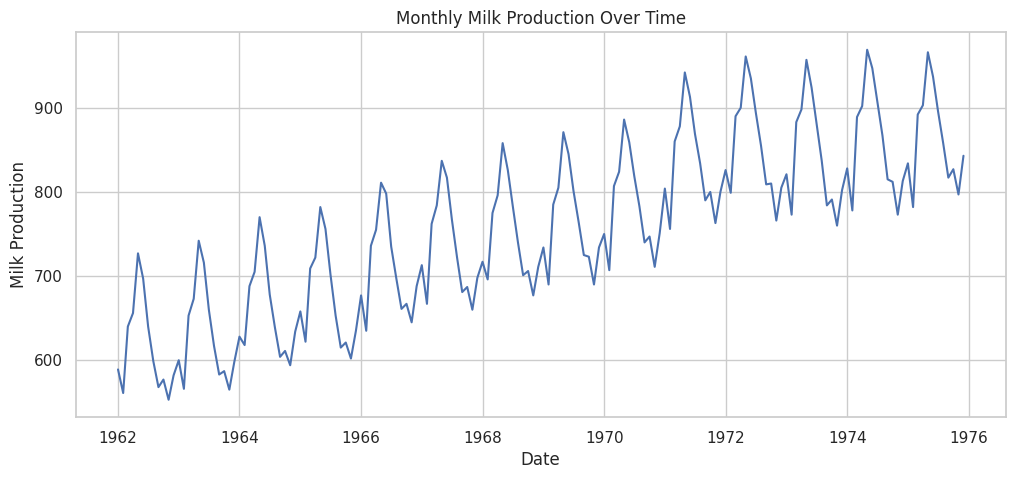

In [29]:
plt.figure(figsize=(12,5))
plt.plot(df['Date'], df['Production'])
plt.title("Monthly Milk Production Over Time")
plt.xlabel("Date")
plt.ylabel("Milk Production")
plt.show()


Text(0.5, 1.0, 'Milk Production Distribution')

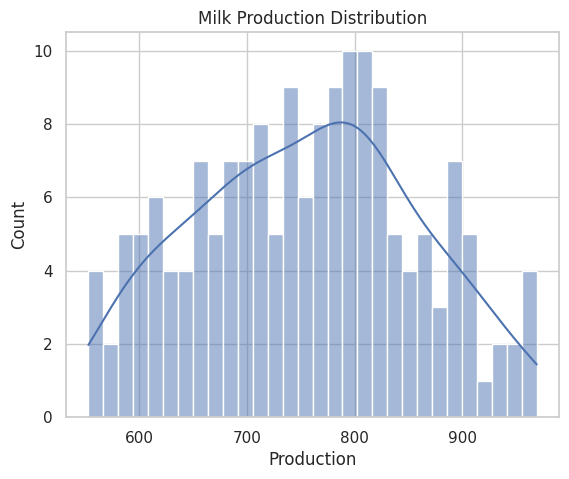

In [30]:
# Distribution and boxplot
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
sns.histplot(df['Production'], bins=30, kde=True)
plt.title('Milk Production Distribution')


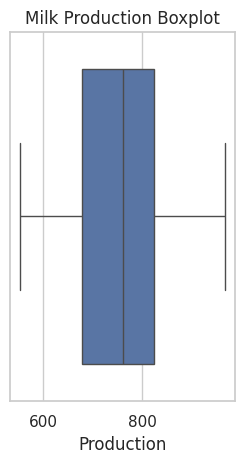

In [31]:

plt.subplot(1,2,2)
sns.boxplot(x=df['Production'])
plt.title('Milk Production Boxplot')
plt.show()


In [32]:
# Scale data
scaler = MinMaxScaler()
production_scaled = scaler.fit_transform(df['Production'].values.reshape(-1, 1))


In [33]:
# Sequence creation
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)


In [34]:
# Train-val-test split
def train_val_test_split(X, y, train_ratio=0.7, val_ratio=0.15):
    n = len(X)
    train_end = int(train_ratio * n)
    val_end = int((train_ratio + val_ratio) * n)

    X_train, y_train = X[:train_end], y[:train_end]
    X_val, y_val = X[train_end:val_end], y[train_end:val_end]
    X_test, y_test = X[val_end:], y[val_end:]
    return X_train, y_train, X_val, y_val, X_test, y_test


In [35]:
# Build model function
def build_model(cell_type, units, window_size):
    model = Sequential()
    if cell_type == 'RNN':
        model.add(SimpleRNN(units, input_shape=(window_size, 1)))
    elif cell_type == 'LSTM':
        model.add(LSTM(units, input_shape=(window_size, 1)))
    elif cell_type == 'GRU':
        model.add(GRU(units, input_shape=(window_size, 1)))
    else:
        raise ValueError("Unknown cell_type")
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model


In [36]:
# Evaluation function
def evaluate_model(model, X, y, scaler):
    y_pred_scaled = model.predict(X)
    y_pred = scaler.inverse_transform(y_pred_scaled)
    y_true = scaler.inverse_transform(y)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return rmse, mae, mape, y_pred, y_true


In [37]:
# Hyperparameter grids
window_sizes = [6, 12, 18]
units_list = [16, 32, 64]
batch_sizes = [16, 32]
epochs_list = [50, 100]
cell_types = ['RNN', 'LSTM', 'GRU']

best_metrics = {}
best_models = {}
best_histories = {}



In [ ]:
# Hyperparameter tuning loop
for cell_type in cell_types:
    best_rmse = np.inf
    best_params = None
    best_model = None
    best_history = None

    for window_size in window_sizes:
        X, y = create_sequences(production_scaled, window_size)
        X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(X, y)
        X_train = X_train.reshape((X_train.shape[0], window_size, 1))
        X_val = X_val.reshape((X_val.shape[0], window_size, 1))
        X_test = X_test.reshape((X_test.shape[0], window_size, 1))
        y_train = y_train.reshape((-1,1))
        y_val = y_val.reshape((-1,1))
        y_test = y_test.reshape((-1,1))

        for units in units_list:
            for batch_size in batch_sizes:
                for epochs in epochs_list:
                    print(f"\nTraining {cell_type} | window={window_size}, units={units}, batch={batch_size}, epochs={epochs}")
                    model = build_model(cell_type, units, window_size)
                    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)
                    history = model.fit(X_train, y_train, validation_data=(X_val,y_val),
                                        epochs=epochs, batch_size=batch_size, callbacks=[early_stop], verbose=0)
                    rmse, mae, mape, _, _ = evaluate_model(model, X_val, y_val, scaler)
                    print(f"Val RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%")
                    if rmse < best_rmse:
                        best_rmse = rmse
                        best_params = {'window_size': window_size, 'units': units, 'batch_size': batch_size, 'epochs': epochs}
                        best_model = model
                        best_history = history

    best_metrics[cell_type] = {'rmse': best_rmse, 'params': best_params}
    best_models[cell_type] = best_model
    best_histories[cell_type] = best_history



Training RNN | window=6, units=16, batch=16, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
Val RMSE: 60.4296, MAE: 46.5914, MAPE: 5.30%

Training RNN | window=6, units=16, batch=16, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
Val RMSE: 52.7279, MAE: 42.3503, MAPE: 4.86%

Training RNN | window=6, units=16, batch=32, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
Val RMSE: 140.8136, MAE: 110.2651, MAPE: 12.37%

Training RNN | window=6, units=16, batch=32, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
Val RMSE: 123.9565, MAE: 97.2638, MAPE: 10.99%

Training RNN | window=6, units=32, batch=16, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
Val RMSE: 41.0588, MAE: 30.2661, MAPE: 3.53%

Training RNN | window=6, units=32, batch=16, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
Val RMSE: 40.1246, MAE: 29.9835, MAPE: 3.51%

Training RNN | window=6, units=32, batch=32, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
Val RMSE: 48.6806, MAE: 33.9356, MAPE: 3.87%

Training RNN | window=6, units=32, batch=32, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
Val RMSE: 44.2474, MAE: 32.4264, MAPE: 3.73%

Training RNN | window=6, units=64, batch=16, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
Val RMSE: 50.0443, MAE: 35.2837, MAPE: 4.07%

Training RNN | window=6, units=64, batch=16, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Val RMSE: 41.4205, MAE: 31.5923, MAPE: 3.71%

Training RNN | window=6, units=64, batch=32, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Val RMSE: 52.0032, MAE: 36.9130, MAPE: 4.17%

Training RNN | window=6, units=64, batch=32, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
Val RMSE: 46.8789, MAE: 36.8630, MAPE: 4.25%

Training RNN | window=12, units=16, batch=16, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
Val RMSE: 43.2004, MAE: 36.0891, MAPE: 4.18%

Training RNN | window=12, units=16, batch=16, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
Val RMSE: 25.7231, MAE: 21.5300, MAPE: 2.56%

Training RNN | window=12, units=16, batch=32, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
Val RMSE: 44.5063, MAE: 36.2560, MAPE: 4.16%

Training RNN | window=12, units=16, batch=32, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Val RMSE: 24.6434, MAE: 19.9865, MAPE: 2.39%

Training RNN | window=12, units=32, batch=16, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
Val RMSE: 26.0965, MAE: 21.0643, MAPE: 2.42%

Training RNN | window=12, units=32, batch=16, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Val RMSE: 20.5715, MAE: 16.1610, MAPE: 1.90%

Training RNN | window=12, units=32, batch=32, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
Val RMSE: 51.5330, MAE: 43.3992, MAPE: 4.99%

Training RNN | window=12, units=32, batch=32, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
Val RMSE: 22.8349, MAE: 19.5564, MAPE: 2.34%

Training RNN | window=12, units=64, batch=16, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
Val RMSE: 21.2219, MAE: 17.7384, MAPE: 2.12%

Training RNN | window=12, units=64, batch=16, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Val RMSE: 19.6593, MAE: 16.0162, MAPE: 1.91%

Training RNN | window=12, units=64, batch=32, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Val RMSE: 31.0295, MAE: 26.3001, MAPE: 3.12%

Training RNN | window=12, units=64, batch=32, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
Val RMSE: 21.8667, MAE: 17.9791, MAPE: 2.15%

Training RNN | window=18, units=16, batch=16, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Val RMSE: 31.9334, MAE: 26.7824, MAPE: 3.16%

Training RNN | window=18, units=16, batch=16, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
Val RMSE: 26.9673, MAE: 21.5908, MAPE: 2.58%

Training RNN | window=18, units=16, batch=32, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
Val RMSE: 61.5227, MAE: 47.2919, MAPE: 5.33%

Training RNN | window=18, units=16, batch=32, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
Val RMSE: 27.9067, MAE: 23.0218, MAPE: 2.75%

Training RNN | window=18, units=32, batch=16, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
Val RMSE: 23.6997, MAE: 18.7913, MAPE: 2.27%

Training RNN | window=18, units=32, batch=16, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
Val RMSE: 18.8884, MAE: 13.3989, MAPE: 1.65%

Training RNN | window=18, units=32, batch=32, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
Val RMSE: 27.3622, MAE: 22.7111, MAPE: 2.64%

Training RNN | window=18, units=32, batch=32, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
Val RMSE: 19.1723, MAE: 16.8042, MAPE: 1.99%

Training RNN | window=18, units=64, batch=16, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
Val RMSE: 19.9822, MAE: 15.8331, MAPE: 1.92%

Training RNN | window=18, units=64, batch=16, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
Val RMSE: 18.1760, MAE: 14.2994, MAPE: 1.70%

Training RNN | window=18, units=64, batch=32, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Val RMSE: 19.3684, MAE: 15.4568, MAPE: 1.86%

Training RNN | window=18, units=64, batch=32, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
Val RMSE: 15.0241, MAE: 12.1250, MAPE: 1.47%

Training LSTM | window=6, units=16, batch=16, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Val RMSE: 78.1160, MAE: 61.6358, MAPE: 6.98%

Training LSTM | window=6, units=16, batch=16, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
Val RMSE: 72.1244, MAE: 58.4122, MAPE: 6.68%

Training LSTM | window=6, units=16, batch=32, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
Val RMSE: 87.7706, MAE: 68.4401, MAPE: 7.70%

Training LSTM | window=6, units=16, batch=32, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
Val RMSE: 79.7817, MAE: 63.6038, MAPE: 7.22%

Training LSTM | window=6, units=32, batch=16, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
Val RMSE: 74.6154, MAE: 64.0808, MAPE: 7.47%

Training LSTM | window=6, units=32, batch=16, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
Val RMSE: 68.7571, MAE: 59.1758, MAPE: 6.93%

Training LSTM | window=6, units=32, batch=32, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
Val RMSE: 75.3174, MAE: 63.0497, MAPE: 7.29%

Training LSTM | window=6, units=32, batch=32, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
Val RMSE: 73.6196, MAE: 62.3279, MAPE: 7.24%

Training LSTM | window=6, units=64, batch=16, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
Val RMSE: 67.5847, MAE: 51.6169, MAPE: 5.82%

Training LSTM | window=6, units=64, batch=16, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
Val RMSE: 65.3448, MAE: 50.0374, MAPE: 5.66%

Training LSTM | window=6, units=64, batch=32, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
Val RMSE: 74.6926, MAE: 64.0438, MAPE: 7.47%

Training LSTM | window=6, units=64, batch=32, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
Val RMSE: 77.2824, MAE: 67.4656, MAPE: 7.93%

Training LSTM | window=12, units=16, batch=16, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
Val RMSE: 68.1938, MAE: 59.2531, MAPE: 6.84%

Training LSTM | window=12, units=16, batch=16, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
Val RMSE: 71.3570, MAE: 59.4164, MAPE: 6.78%

Training LSTM | window=12, units=16, batch=32, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
Val RMSE: 64.7074, MAE: 55.6364, MAPE: 6.43%

Training LSTM | window=12, units=16, batch=32, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
Val RMSE: 70.9359, MAE: 59.2135, MAPE: 6.76%

Training LSTM | window=12, units=32, batch=16, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
Val RMSE: 67.3172, MAE: 60.6278, MAPE: 7.22%

Training LSTM | window=12, units=32, batch=16, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
Val RMSE: 29.5745, MAE: 25.3770, MAPE: 3.01%

Training LSTM | window=12, units=32, batch=32, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
Val RMSE: 67.2251, MAE: 61.0832, MAPE: 7.22%

Training LSTM | window=12, units=32, batch=32, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
Val RMSE: 24.6769, MAE: 20.5406, MAPE: 2.41%

Training LSTM | window=12, units=64, batch=16, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
Val RMSE: 33.0631, MAE: 25.9847, MAPE: 3.15%

Training LSTM | window=12, units=64, batch=16, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
Val RMSE: 32.0329, MAE: 25.5644, MAPE: 3.09%

Training LSTM | window=12, units=64, batch=32, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
Val RMSE: 27.3544, MAE: 21.3289, MAPE: 2.53%

Training LSTM | window=12, units=64, batch=32, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
Val RMSE: 35.0848, MAE: 28.5904, MAPE: 3.49%

Training LSTM | window=18, units=16, batch=16, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
Val RMSE: 68.2825, MAE: 55.9290, MAPE: 6.40%

Training LSTM | window=18, units=16, batch=16, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
Val RMSE: 75.4076, MAE: 60.7581, MAPE: 6.91%

Training LSTM | window=18, units=16, batch=32, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
Val RMSE: 65.2248, MAE: 56.1260, MAPE: 6.54%

Training LSTM | window=18, units=16, batch=32, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
Val RMSE: 64.2513, MAE: 56.3104, MAPE: 6.60%

Training LSTM | window=18, units=32, batch=16, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
Val RMSE: 67.4509, MAE: 60.3099, MAPE: 7.11%

Training LSTM | window=18, units=32, batch=16, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
Val RMSE: 34.4317, MAE: 26.7753, MAPE: 3.22%

Training LSTM | window=18, units=32, batch=32, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
Val RMSE: 67.0999, MAE: 58.1857, MAPE: 6.78%

Training LSTM | window=18, units=32, batch=32, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
Val RMSE: 69.4214, MAE: 61.5817, MAPE: 7.21%

Training LSTM | window=18, units=64, batch=16, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
Val RMSE: 31.7670, MAE: 23.0519, MAPE: 2.76%

Training LSTM | window=18, units=64, batch=16, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
Val RMSE: 28.7490, MAE: 21.3500, MAPE: 2.55%

Training LSTM | window=18, units=64, batch=32, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
Val RMSE: 61.2676, MAE: 54.2370, MAPE: 6.48%

Training LSTM | window=18, units=64, batch=32, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
Val RMSE: 46.3693, MAE: 36.0835, MAPE: 4.34%

Training GRU | window=6, units=16, batch=16, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
Val RMSE: 57.2954, MAE: 44.5093, MAPE: 5.07%

Training GRU | window=6, units=16, batch=16, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
Val RMSE: 45.0815, MAE: 35.8935, MAPE: 4.15%

Training GRU | window=6, units=16, batch=32, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
Val RMSE: 71.1654, MAE: 55.3316, MAPE: 6.25%

Training GRU | window=6, units=16, batch=32, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
Val RMSE: 101.2570, MAE: 82.4957, MAPE: 9.29%

Training GRU | window=6, units=32, batch=16, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
Val RMSE: 57.9309, MAE: 48.8767, MAPE: 5.70%

Training GRU | window=6, units=32, batch=16, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
Val RMSE: 61.9254, MAE: 52.3354, MAPE: 6.08%

Training GRU | window=6, units=32, batch=32, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
Val RMSE: 58.5302, MAE: 48.9175, MAPE: 5.69%

Training GRU | window=6, units=32, batch=32, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
Val RMSE: 77.8360, MAE: 60.3277, MAPE: 6.79%

Training GRU | window=6, units=64, batch=16, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
Val RMSE: 39.2084, MAE: 30.6339, MAPE: 3.60%

Training GRU | window=6, units=64, batch=16, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
Val RMSE: 38.8318, MAE: 29.0757, MAPE: 3.42%

Training GRU | window=6, units=64, batch=32, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
Val RMSE: 68.5179, MAE: 57.5913, MAPE: 6.66%

Training GRU | window=6, units=64, batch=32, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
Val RMSE: 62.8629, MAE: 54.0777, MAPE: 6.36%

Training GRU | window=12, units=16, batch=16, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
Val RMSE: 74.8133, MAE: 57.5512, MAPE: 6.45%

Training GRU | window=12, units=16, batch=16, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
Val RMSE: 41.7668, MAE: 32.6903, MAPE: 3.77%

Training GRU | window=12, units=16, batch=32, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
Val RMSE: 56.8764, MAE: 47.5257, MAPE: 5.52%

Training GRU | window=12, units=16, batch=32, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
Val RMSE: 67.0523, MAE: 52.2017, MAPE: 5.91%

Training GRU | window=12, units=32, batch=16, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
Val RMSE: 62.7128, MAE: 53.4592, MAPE: 6.20%

Training GRU | window=12, units=32, batch=16, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
Val RMSE: 30.3361, MAE: 25.4147, MAPE: 3.03%

Training GRU | window=12, units=32, batch=32, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
Val RMSE: 65.4358, MAE: 56.4520, MAPE: 6.55%

Training GRU | window=12, units=32, batch=32, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
Val RMSE: 64.4592, MAE: 54.0177, MAPE: 6.23%

Training GRU | window=12, units=64, batch=16, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
Val RMSE: 68.4005, MAE: 61.8723, MAPE: 7.31%

Training GRU | window=12, units=64, batch=16, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
Val RMSE: 31.2463, MAE: 25.6036, MAPE: 3.05%

Training GRU | window=12, units=64, batch=32, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
Val RMSE: 62.7056, MAE: 54.7659, MAPE: 6.43%

Training GRU | window=12, units=64, batch=32, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
Val RMSE: 65.7601, MAE: 56.4946, MAPE: 6.56%

Training GRU | window=18, units=16, batch=16, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
Val RMSE: 67.1921, MAE: 52.7856, MAPE: 5.98%

Training GRU | window=18, units=16, batch=16, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
Val RMSE: 33.1338, MAE: 24.6187, MAPE: 2.89%

Training GRU | window=18, units=16, batch=32, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
Val RMSE: 82.5516, MAE: 64.0912, MAPE: 7.17%

Training GRU | window=18, units=16, batch=32, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
Val RMSE: 66.6857, MAE: 52.2479, MAPE: 5.91%

Training GRU | window=18, units=32, batch=16, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
Val RMSE: 57.2394, MAE: 49.2576, MAPE: 5.81%

Training GRU | window=18, units=32, batch=16, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
Val RMSE: 61.5736, MAE: 52.2957, MAPE: 6.08%

Training GRU | window=18, units=32, batch=32, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
Val RMSE: 64.8967, MAE: 53.5568, MAPE: 6.16%

Training GRU | window=18, units=32, batch=32, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
Val RMSE: 60.3319, MAE: 51.3398, MAPE: 6.00%

Training GRU | window=18, units=64, batch=16, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
Val RMSE: 32.2349, MAE: 23.9245, MAPE: 2.84%

Training GRU | window=18, units=64, batch=16, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
Val RMSE: 30.3927, MAE: 23.1934, MAPE: 2.76%

Training GRU | window=18, units=64, batch=32, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
Val RMSE: 64.8942, MAE: 56.1937, MAPE: 6.58%

Training GRU | window=18, units=64, batch=32, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
Val RMSE: 61.2637, MAE: 52.4923, MAPE: 6.17%


In [ ]:
# Summary of best hyperparameters and metrics
print("\nBest Hyperparameters and Validation RMSE:")
for model_type, vals in best_metrics.items():
    print(f"{model_type}: RMSE={vals['rmse']:.4f} with params {vals['params']}")



Best Hyperparameters and Validation RMSE:
RNN: RMSE=15.0241 with params {'window_size': 18, 'units': 64, 'batch_size': 32, 'epochs': 100}
LSTM: RMSE=24.6769 with params {'window_size': 12, 'units': 32, 'batch_size': 32, 'epochs': 100}
GRU: RMSE=30.3361 with params {'window_size': 12, 'units': 32, 'batch_size': 16, 'epochs': 100}


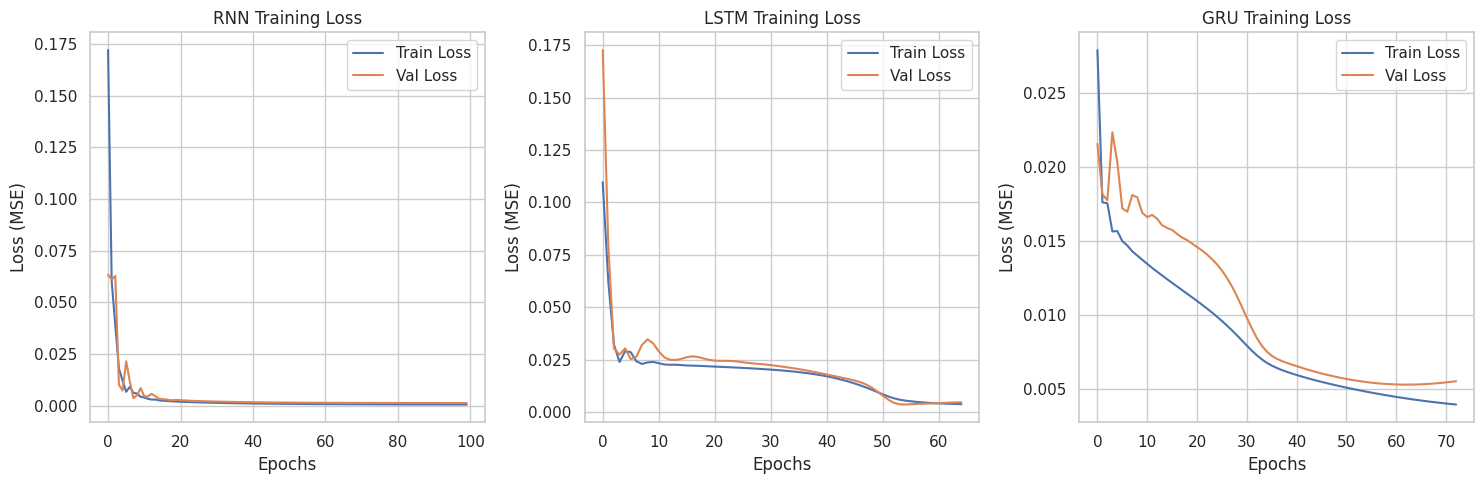

In [ ]:
# Plot training-loss curves for best models
plt.figure(figsize=(15,5))
for i, model_type in enumerate(cell_types, 1):
    history = best_histories[model_type]
    plt.subplot(1,3,i)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f"{model_type} Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss (MSE)")
    plt.legend()
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step

Test performance for RNN - RMSE:11.8840, MAE:10.0004, MAPE:1.15%


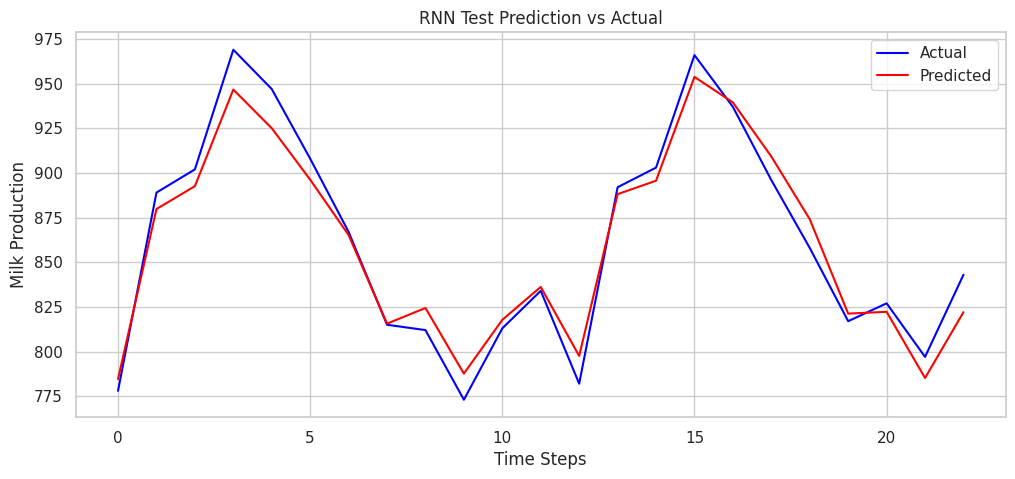

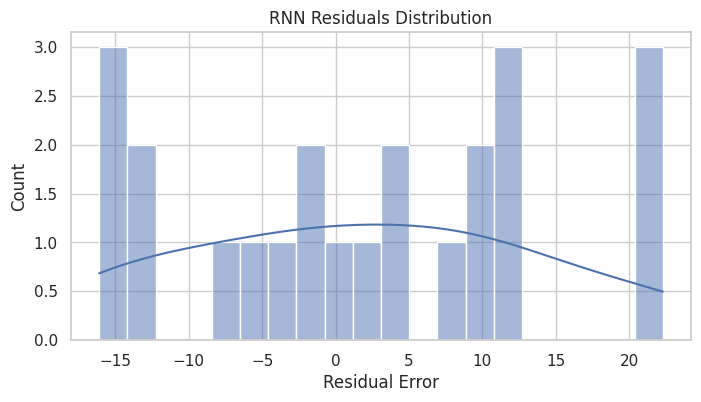

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step

Test performance for LSTM - RMSE:29.5647, MAE:24.5325, MAPE:2.84%


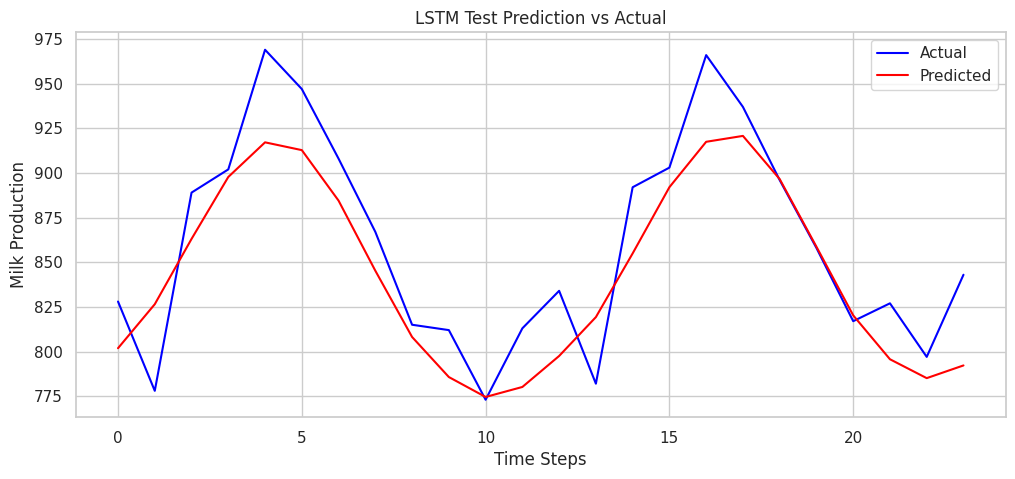

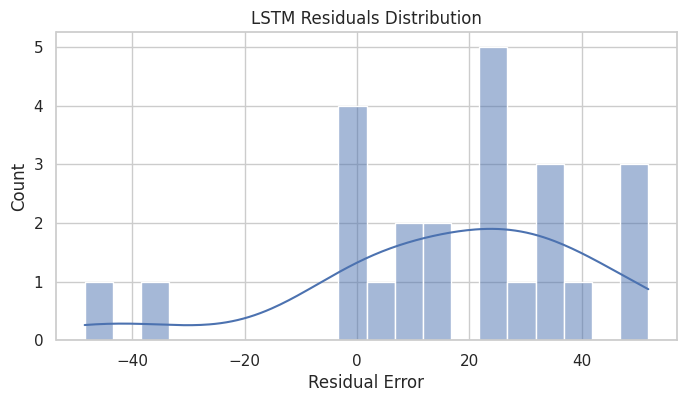

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step

Test performance for GRU - RMSE:31.3045, MAE:25.5735, MAPE:3.01%


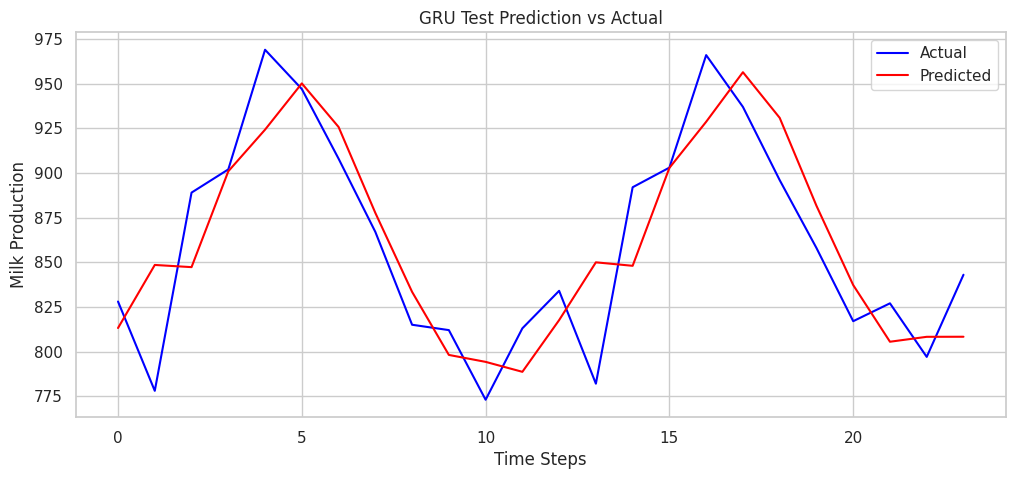

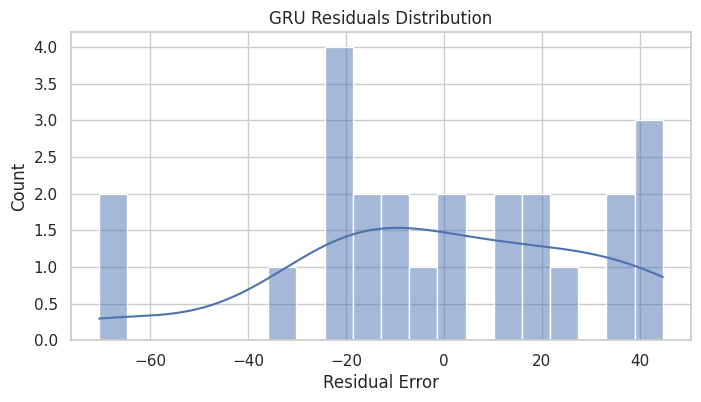

In [ ]:

# Evaluate best models on test set and plot predictions
for model_type in cell_types:
    params = best_metrics[model_type]['params']
    window_size = params['window_size']

    X, y = create_sequences(production_scaled, window_size)
    _, _, _, _, X_test, y_test = train_val_test_split(X, y)
    X_test = X_test.reshape((X_test.shape[0], window_size, 1))
    y_test = y_test.reshape((-1, 1))

    model = best_models[model_type]
    rmse, mae, mape, y_pred, y_true = evaluate_model(model, X_test, y_test, scaler)

    print(f"\nTest performance for {model_type} - RMSE:{rmse:.4f}, MAE:{mae:.4f}, MAPE:{mape:.2f}%")

    plt.figure(figsize=(12,5))
    plt.plot(y_true, label='Actual', color='blue')
    plt.plot(y_pred, label='Predicted', color='red')
    plt.title(f'{model_type} Test Prediction vs Actual')
    plt.xlabel('Time Steps')
    plt.ylabel('Milk Production')
    plt.legend()
    plt.show()

    residuals = y_true - y_pred
    plt.figure(figsize=(8,4))
    sns.histplot(residuals.flatten(), bins=20, kde=True)
    plt.title(f'{model_type} Residuals Distribution')
    plt.xlabel('Residual Error')
    plt.show()



Interpretation:
- The model with the lowest RMSE on test set is considered 'best' for point forecasting in this experiment.
- LSTM/GRU often capture longer temporal dependencies and seasonality better than a vanilla RNN.
- If the best model still shows large MAPE, consider additional feature engineering (exogenous regressors like temperature, feed inputs),
  or increase model capacity and training epochs, or use seasonal decomposition + model residuals.
Practical recommendations:
- Use the 12-month point forecasts for inventory planning, but apply a conservative safety stock considering forecast uncertainty.
- Re-train models monthly as new data arrives (rolling/online retraining).
- For production use, evaluate forecast on out-of-sample holdout (or cross-validated time-series splits).

